In [1]:
library(anndata)
library(Signac)
library(Seurat)
library(anndata)
library(ggplot2)
library(tidyverse)
library(Signac)
library(Seurat)
#library(EnsDb.Mmusculus.v102)
library(BSgenome.Mmusculus.UCSC.mm10)
#library(pastecs)
library(stringr)

Attaching SeuratObject

Attaching sp

── Attaching packages ───────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ readr::read_csv() masks anndata::read_csv()
✖ purrr::reduce()   masks Signac::reduce()
Lade nötiges Paket: BSgenome

Lade nötiges Paket: BiocGenerics


Attache Paket: ‘BiocGenerics’


Die folgenden Objekte sind maskiert von ‘package:dplyr’:

    combine, intersect, setdiff, union


Die folgenden Objekte sind maskiert von ‘package:stats’:

    IQR, mad, sd, var, xtabs


Die folgenden Objekte sind maskiert von ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data

In [2]:
seurat <- readRDS("/Users/dominik.klein/data/seurat_new_annotations.rds")

In [3]:
delta_markers <- c("Hhex",
"Fchsd1",
"Sla2",
"Plac8",
"Slc2a3",
"Gm2109",
"Cer1",
"Cacna1h",
"Dpysl3",
"Masp1",
"Nrsn1",
"Glis1",
"Ptpro",
"Kctd8",
"Lingo1",
"Spock3",
"Kcnc2",
"Dscam",
"Bmp3",
"Ptprz1",
"Cfap61",
"Luzp2",
"Shisal2b",
"Mapk10",
"Gap43",
"Ngb",
"Egr3",
"Stxbp5l",
"Mef2c",
"Ppp1r17",
"Cbln4",
"Ly6h",
"F5",
"Dpp6",
"Cfap61",
"Syt1",
"Nptx2",
"Rgs9",
"Cidea",
"Unc5c",
"Sst")

In [178]:
seurat <- LinkPeaks(
  object = seurat,
  peak.assay = "ATAC_merged",
  expression.assay = "RNA",
  genes.use = delta_markers
)

Testing 39 genes and 228257 peaks



In [179]:
get_link_ranges <- function(object, assay, gene, n_links=0, upstream=0.05, downstream=0.05, smooth.spline.spar=0.65){
  # Gets the entire range of the n_links top peak-gene links of a given gene and the gene itself
  # object = seurat object
  # assay = ATAC/Peaks assay with links and annotation
  # gene = Gene for which links should be found
  # n_links = number of links to be included. If 0, estimate number of top links.
  # upstream/downstream = number of bases to add up/downstream. If < 1: defines the fraction of the total length that is added.
  
  # TO DO: score cut-off (abs scores)
  #detach("package:MOFA2", unload = TRUE)
  # get links for gene
  links_df <- as.data.frame(object[[assay]]@links[object[[assay]]@links$gene==gene])
  if (dim(links_df)[1] == 0){
      print("No links detected for this gene")
      return(list(c(0, 0)))
      }
  n_links <- nrow(links_df)
  links_df$abs_score <- abs(links_df$score)
  links_df <- links_df[order(links_df$abs_score, decreasing = TRUE),]
  links_df$rank <- seq(1,nrow(links_df))
  
  if (n_links == 0){
    # estimate top links
    model <- smooth.spline(x = links_df$rank, y = links_df$abs_score, spar = smooth.spline.spar, tol=1e-1)
    n_links <- which.max(stats::predict(model,  deriv = 2)$y)
  } 
  # get gene ranges
  gene_ranges <- data.frame(object[[assay]]@annotation@ranges[which(object[[assay]]@annotation$gene_name==gene)])[,c("start","end")]
  
  # get link ranges
  link_ranges <- links_df[1:n_links,c("start","end")]
  
  # get merge ranges
  ranges <- rbind(gene_ranges, link_ranges)
  chr <- links_df$seqnames[1]
  start <- min(ranges$start)
  end <- max(ranges$end)
  
  # add up/downstream ranges
  width <- end - start
  
  if (downstream < 1){
    downstream <- as.integer(width*downstream)
  }
  
  if (upstream < 1){
    upstream <- as.integer(width*upstream)
  }
  
  start <- start - upstream
  end <- end + downstream
  
  #plot link scores
  print(ggplot(links_df, aes(x=rank, y=abs_score)) + geom_point(color="firebrick") + geom_vline(xintercept = n_links, linetype=2) + labs(x="Rank", y="Absolute Score", title=paste0("Top Links (",n_links,")")))
  
  # return
  final_range <- GenomicRanges::GRanges(seqnames = chr, ranges = IRanges(start, end))
  final_range$gene <- gene
  return(list(final_range, links_df))
  # return(list("chr"=chr, 
  #                   "start"=start,
  #                   "end"=end,
  #                   "gene"=gene))
}

In [180]:
get_results <- function(object, ident, gene, n_links=3, downstream=0.2, assay="ATAC_merged"){
    Idents(object) <- seurat@meta.data[[ident]]
    res <- get_link_ranges(object = object, assay = assay, gene = gene, n_links = n_links, downstream = downstream)
    n_links <- nrow(res[[2]])
    range <- res[[1]]
    coverage <- CoveragePlot(
      object = seurat,
      region = range,
      features = range$gene,
      expression.assay = "RNA",
      annotation = FALSE,
      peaks = FALSE,
      links = FALSE
    )
    
    anno <- AnnotationPlot(object = seurat, region = range)

    #peaks <- PeakPlot(object = seurat, region = range, group.by = "count") + scale_color_gradient("Counts", low = "gray85", high = "black")
    peaks <- PeakPlot(object = seurat, region = range, color = "black") 

    links <- LinkPlot(object = seurat, region = range)  + scale_color_gradient2(low = "#d8002d", mid = "gray95",high = "#0075d7", midpoint = 0)#+ scale_color_viridis_c("Score",option = "mako", begin = 0.25, end = 1, direction = -1) #

    expression <- ExpressionPlot(
      object = seurat,
      features = range$gene,
      assay = "RNA"
    )

    combined <- CombineTracks(
      plotlist = list(coverage, anno, peaks, links),
      expression.plot = expression, 
      heights = c(8, 2, 1, 3),
      widths = c(18, 2)
    )

    print(combined)
    
    for (i in c(1:n_links)){
        feature <- res[[2]]$peak[i]
        counts <- as.vector(seurat[feature,][[assay]]@data)
        celltype <- seurat@meta.data[[ident]]
        data <- as_tibble(data.frame(counts, celltype))
        statistics <- data %>% group_by(celltype) %>% summarise(mean = mean(counts), n = n(), q25 = quantile(counts, 0.25), q50 = quantile(counts, 0.5), q75 = quantile(counts, 0.75), q90 = quantile(counts, 0.9))
        print(feature)
        print(statistics)

        #p <- ggplot(as_tibble(data), aes(factor(ident), counts)) + 
        #geom_violin() + 
        #geom_boxplot(width=.1) + 
        #labs(title = feature, x = "cluster", y = "normalized counts") + 
        #theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
        #print(p)
    }
    }

In [177]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[1]])

[1] "No links detected for this gene"


ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'nrow': Indizierung außerhalb der Grenzen


In [148]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[2]])

[1] "No links detected for this gene"


ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'nrow': Indizierung außerhalb der Grenzen


In [149]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[3]])

[1] "No links detected for this gene"


ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'nrow': Indizierung außerhalb der Grenzen


In [150]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[4]])

[1] "No links detected for this gene"


ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'nrow': Indizierung außerhalb der Grenzen


In [151]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[5]])

[1] "No links detected for this gene"


ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'nrow': Indizierung außerhalb der Grenzen


In [152]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[6]])

[1] "No links detected for this gene"


ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'nrow': Indizierung außerhalb der Grenzen


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message:
“Removed 71 rows containing missing values (geom_segment).”


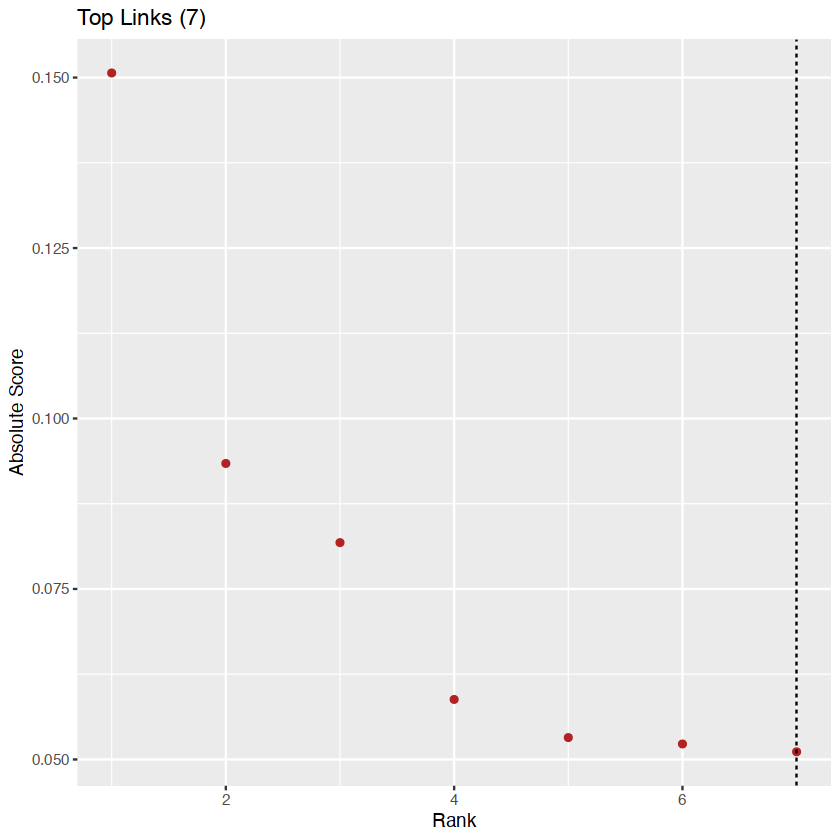

[1] "4-82884752-82885662"
# A tibble: 18 × 6
   celltype             mean     n   q25   q50   q75
   <chr>               <dbl> <int> <dbl> <dbl> <dbl>
 1 Alpha             0.161     460     0 0     0    
 2 Beta              0.219     588     0 0     0    
 3 Delta             0.468      77     0 0     1.26 
 4 Ductal            0.0447   2906     0 0     0    
 5 Eps. progenitors  0.646     204     0 0     1.36 
 6 Epsilon           0.419     247     0 0     0.938
 7 Fev+              0.352    1134     0 0     0    
 8 Fev+ Alpha        0.176     433     0 0     0    
 9 Fev+ Beta         0.209     833     0 0     0    
10 Fev+ Delta,0      0.537      61     0 0     1.23 
11 Fev+ Delta,1      0.356      60     0 0     0.287
12 Fev+ Delta,2      0.520      55     0 0     1.49 
13 Imm. Acinar       0.0350   1928     0 0     0    
14 Mat. Acinar       0.00911  1322     0 0     0    
15 Ngn3 high         0.499    3898     0 0     1.24 
16 Ngn3 high cycling 0.758     139     0 0.844 1.36 
1

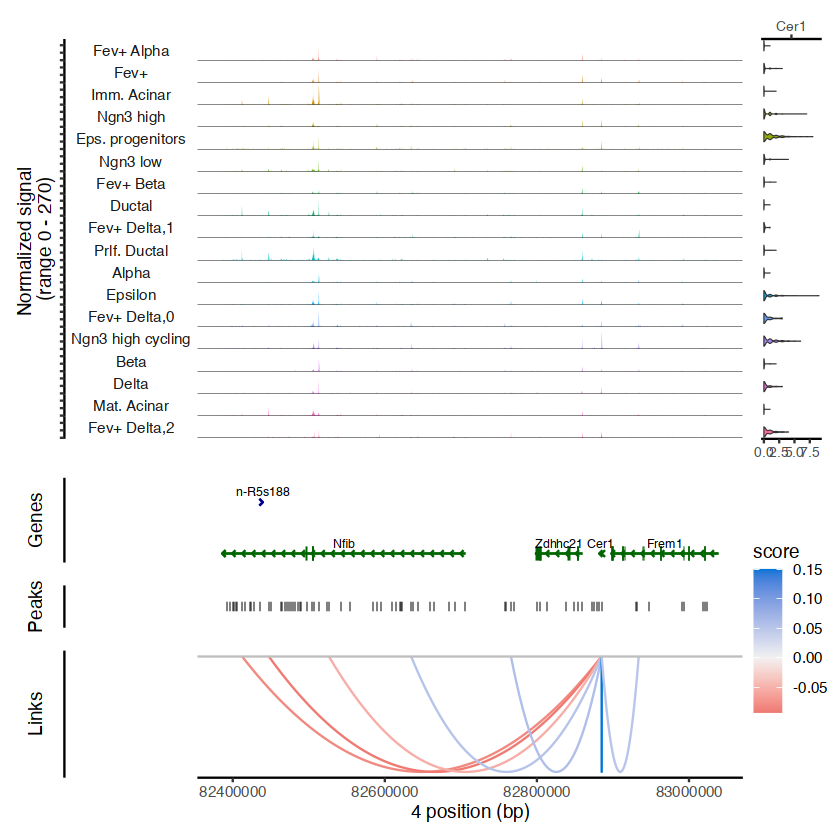

In [153]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[7]])

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message:
“Removed 47 rows containing missing values (geom_segment).”


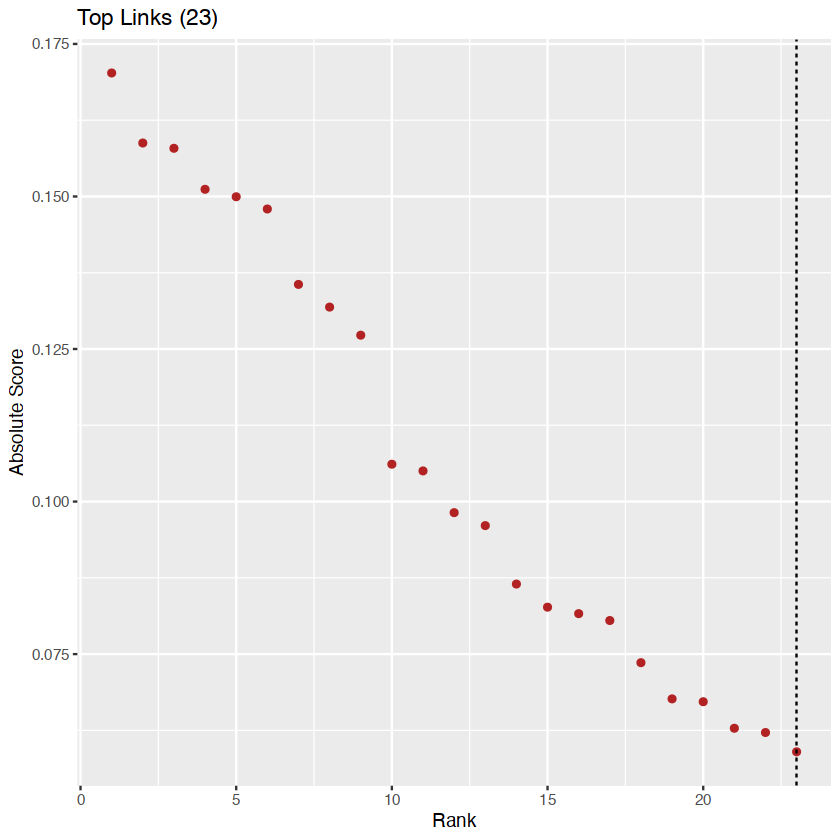

[1] "17-25802832-25803742"
# A tibble: 18 × 6
   celltype            mean     n   q25   q50   q75
   <chr>              <dbl> <int> <dbl> <dbl> <dbl>
 1 Alpha             0.512    460     0 0     1.14 
 2 Beta              0.474    588     0 0     1.18 
 3 Delta             0.467     77     0 0     1.26 
 4 Ductal            0.0773  2906     0 0     0    
 5 Eps. progenitors  0.594    204     0 0     1.27 
 6 Epsilon           0.666    247     0 0     1.32 
 7 Fev+              0.516   1134     0 0     1.06 
 8 Fev+ Alpha        0.568    433     0 0     1.22 
 9 Fev+ Beta         0.468    833     0 0     1.07 
10 Fev+ Delta,0      0.638     61     0 0.653 1.25 
11 Fev+ Delta,1      0.508     60     0 0     0.993
12 Fev+ Delta,2      0.499     55     0 0     1.18 
13 Imm. Acinar       0.0598  1928     0 0     0    
14 Mat. Acinar       0.0199  1322     0 0     0    
15 Ngn3 high         0.455   3898     0 0     1.00 
16 Ngn3 high cycling 0.472    139     0 0     0.966
17 Ngn3 low       

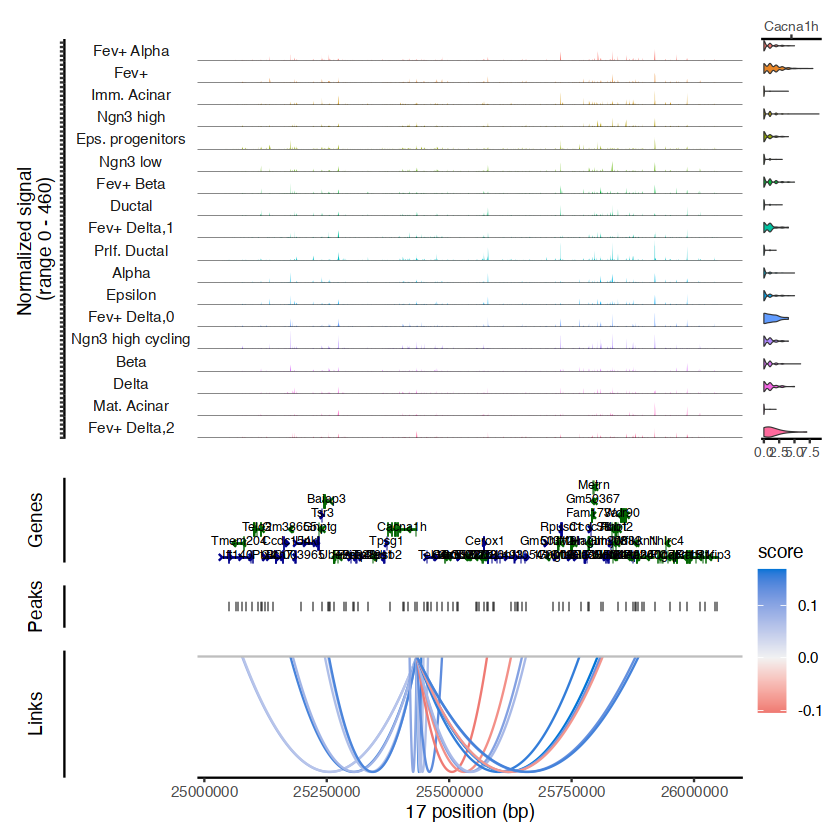

In [154]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[8]])

In [155]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[9]])

[1] "No links detected for this gene"


ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'nrow': Indizierung außerhalb der Grenzen


In [156]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[10]])

[1] "No links detected for this gene"


ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'nrow': Indizierung außerhalb der Grenzen


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



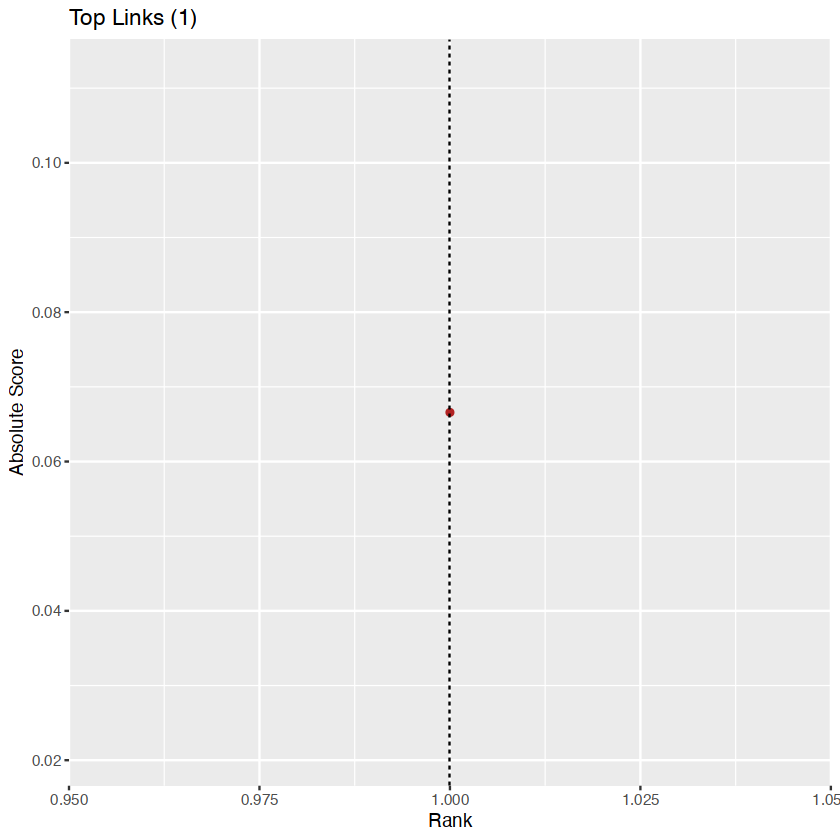

[1] "13-25625413-25626316"
# A tibble: 18 × 6
   celltype             mean     n   q25   q50   q75
   <chr>               <dbl> <int> <dbl> <dbl> <dbl>
 1 Alpha             0.842     460     0     0  2.52
 2 Beta              0.195     588     0     0  0   
 3 Delta             0.186      77     0     0  0   
 4 Ductal            0.0205   2906     0     0  0   
 5 Eps. progenitors  0.0984    204     0     0  0   
 6 Epsilon           0.412     247     0     0  0   
 7 Fev+              0.102    1134     0     0  0   
 8 Fev+ Alpha        0.384     433     0     0  0   
 9 Fev+ Beta         0.152     833     0     0  0   
10 Fev+ Delta,0      0.151      61     0     0  0   
11 Fev+ Delta,1      0.703      60     0     0  0   
12 Fev+ Delta,2      0.379      55     0     0  0   
13 Imm. Acinar       0.0138   1928     0     0  0   
14 Mat. Acinar       0.00653  1322     0     0  0   
15 Ngn3 high         0.0310   3898     0     0  0   
16 Ngn3 high cycling 0.0875    139     0     0  0   


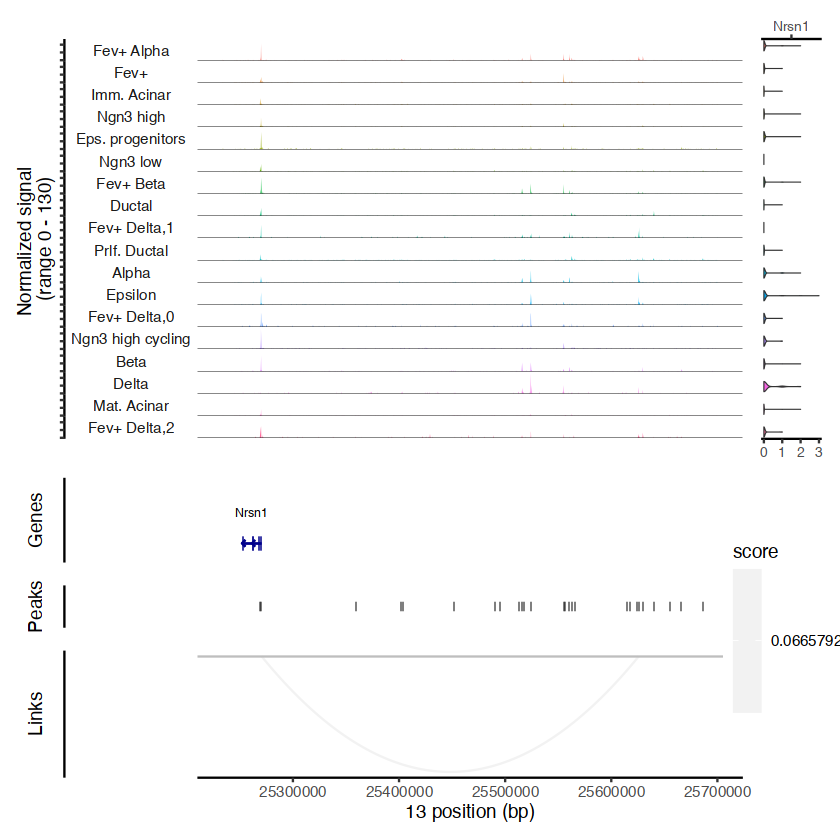

In [157]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[11]])

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



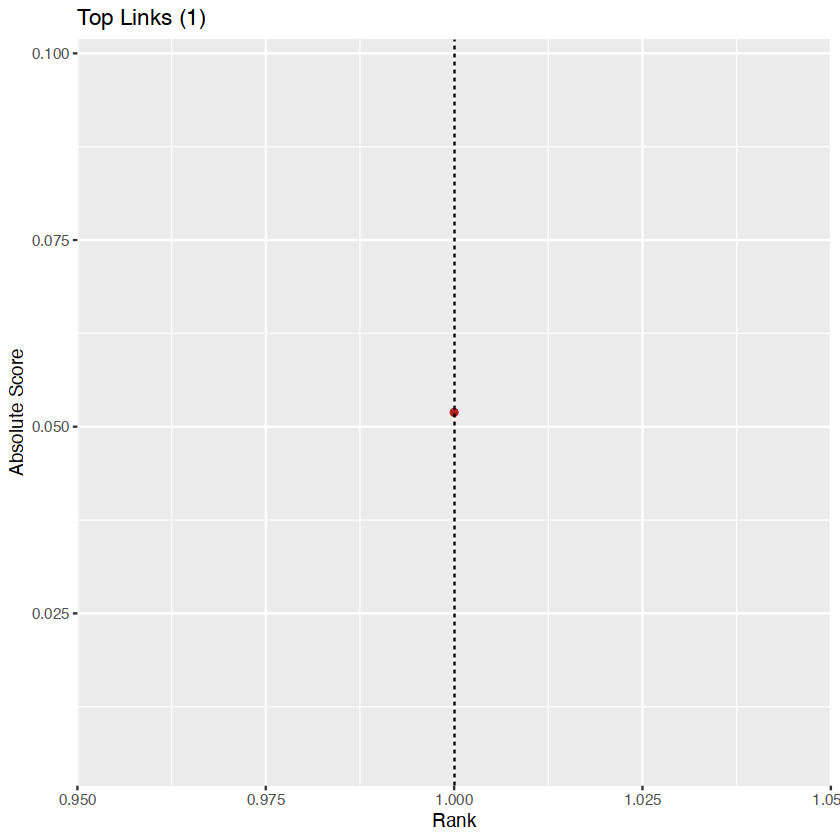

[1] "4-107525372-107526262"
# A tibble: 18 × 6
   celltype            mean     n   q25   q50   q75
   <chr>              <dbl> <int> <dbl> <dbl> <dbl>
 1 Alpha             0.339    460     0     0     0
 2 Beta              0.215    588     0     0     0
 3 Delta             0.0416    77     0     0     0
 4 Ductal            0.0135  2906     0     0     0
 5 Eps. progenitors  0.0383   204     0     0     0
 6 Epsilon           0.307    247     0     0     0
 7 Fev+              0.191   1134     0     0     0
 8 Fev+ Alpha        0.577    433     0     0     0
 9 Fev+ Beta         0.175    833     0     0     0
10 Fev+ Delta,0      0.242     61     0     0     0
11 Fev+ Delta,1      0.530     60     0     0     0
12 Fev+ Delta,2      0.171     55     0     0     0
13 Imm. Acinar       0.0257  1928     0     0     0
14 Mat. Acinar       0.0109  1322     0     0     0
15 Ngn3 high         0.0676  3898     0     0     0
16 Ngn3 high cycling 0.0462   139     0     0     0
17 Ngn3 low      

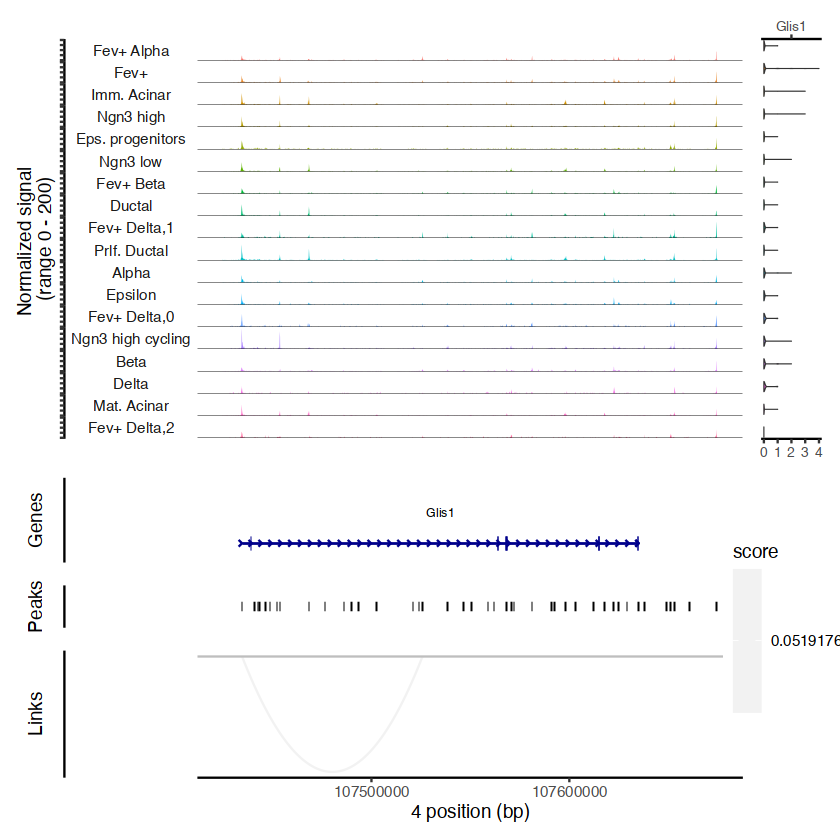

In [158]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[12]])

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message:
“Removed 4 rows containing missing values (geom_segment).”


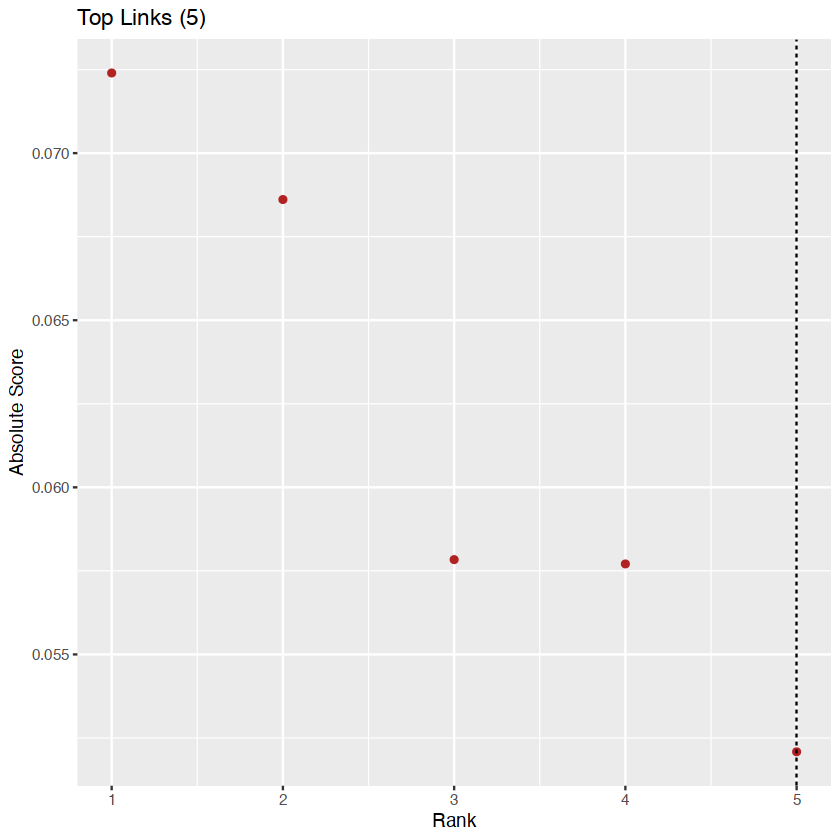

[1] "6-137281841-137282860"
# A tibble: 18 × 6
   celltype            mean     n   q25   q50   q75
   <chr>              <dbl> <int> <dbl> <dbl> <dbl>
 1 Alpha             0.0601   460     0     0     0
 2 Beta              0.0288   588     0     0     0
 3 Delta             0.108     77     0     0     0
 4 Ductal            0.0203  2906     0     0     0
 5 Eps. progenitors  0.327    204     0     0     0
 6 Epsilon           0.148    247     0     0     0
 7 Fev+              0.124   1134     0     0     0
 8 Fev+ Alpha        0.0416   433     0     0     0
 9 Fev+ Beta         0.0787   833     0     0     0
10 Fev+ Delta,0      0.124     61     0     0     0
11 Fev+ Delta,1      0.0858    60     0     0     0
12 Fev+ Delta,2      0.0658    55     0     0     0
13 Imm. Acinar       0.0200  1928     0     0     0
14 Mat. Acinar       0.0220  1322     0     0     0
15 Ngn3 high         0.250   3898     0     0     0
16 Ngn3 high cycling 0.275    139     0     0     0
17 Ngn3 low      

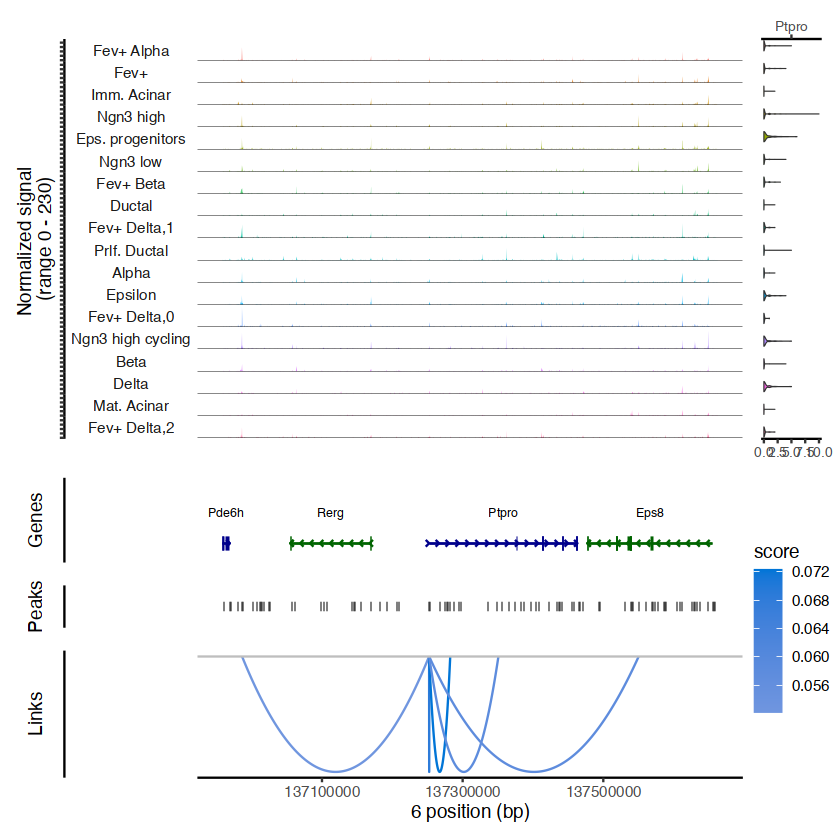

In [159]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[13]])

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



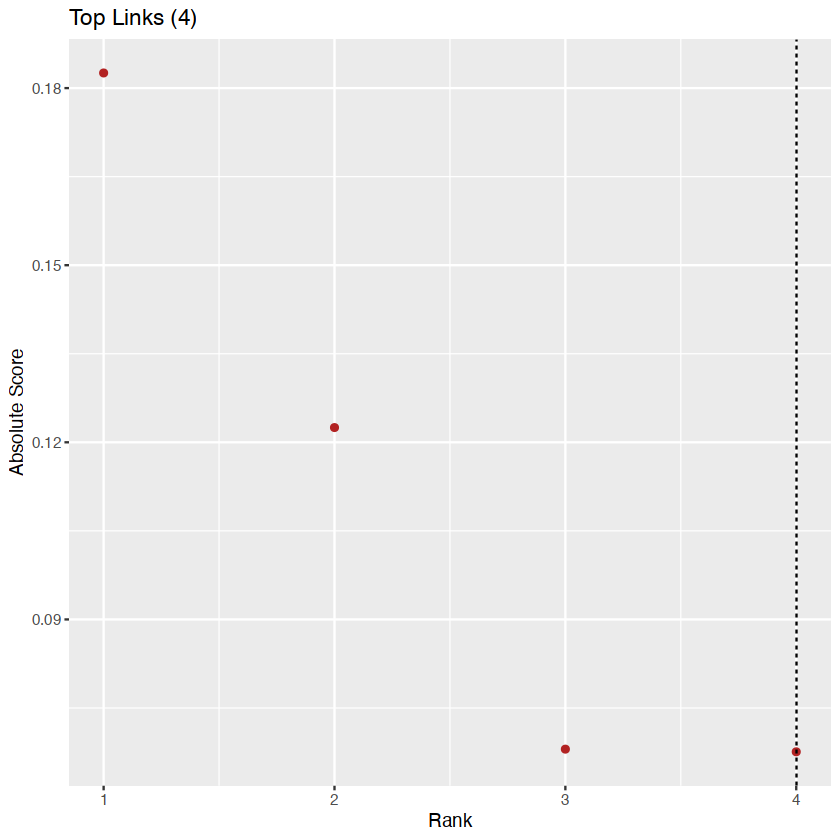

[1] "5-69338695-69339633"
# A tibble: 18 × 6
   celltype            mean     n   q25   q50   q75
   <chr>              <dbl> <int> <dbl> <dbl> <dbl>
 1 Alpha             0.717    460     0     0  1.85
 2 Beta              0.699    588     0     0  1.91
 3 Delta             0.972     77     0     0  2.14
 4 Ductal            0.0340  2906     0     0  0   
 5 Eps. progenitors  0.434    204     0     0  0   
 6 Epsilon           0.648    247     0     0  1.71
 7 Fev+              0.166   1134     0     0  0   
 8 Fev+ Alpha        0.291    433     0     0  0   
 9 Fev+ Beta         0.661    833     0     0  1.77
10 Fev+ Delta,0      0.692     61     0     0  1.71
11 Fev+ Delta,1      0.925     60     0     0  1.82
12 Fev+ Delta,2      0.687     55     0     0  1.98
13 Imm. Acinar       0.0420  1928     0     0  0   
14 Mat. Acinar       0.0400  1322     0     0  0   
15 Ngn3 high         0.122   3898     0     0  0   
16 Ngn3 high cycling 0.138    139     0     0  0   
17 Ngn3 low        

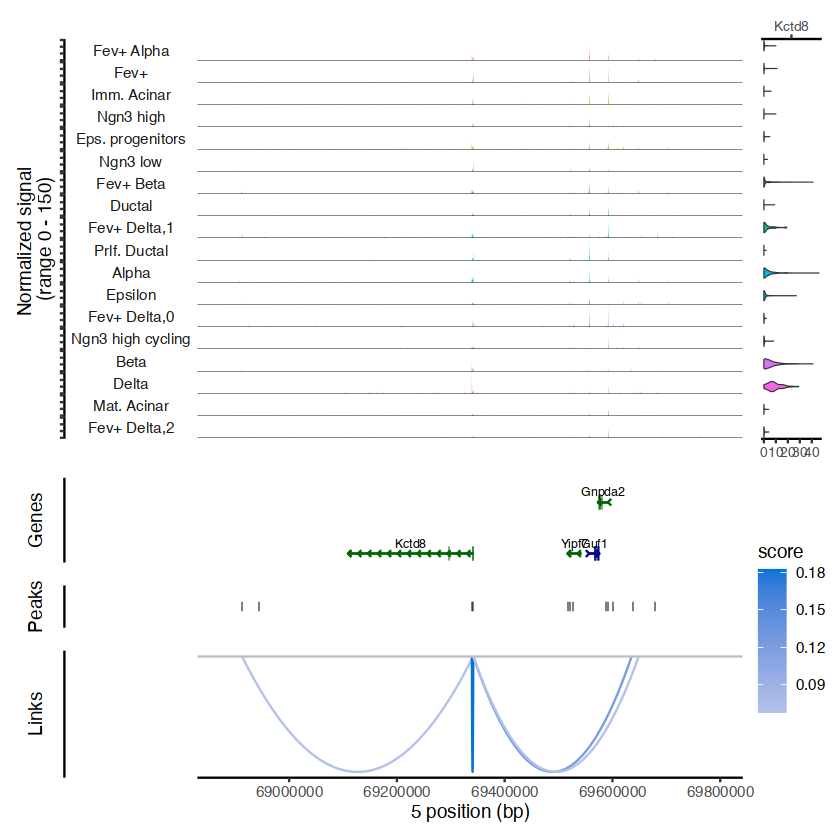

In [160]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[14]])

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message:
“Removed 10 rows containing missing values (geom_segment).”


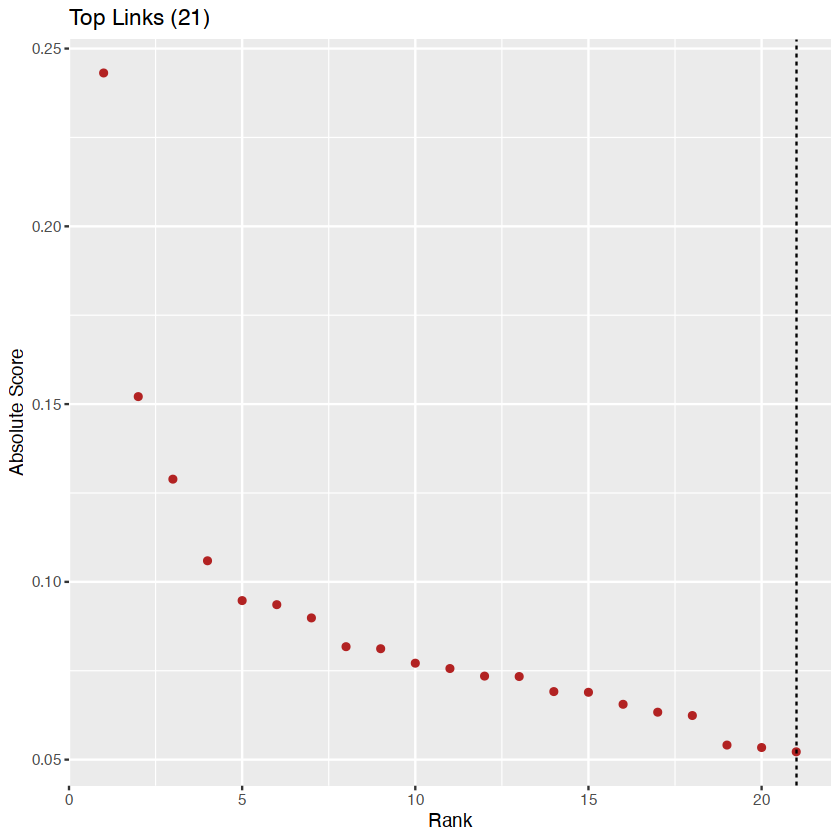

[1] "9-56791437-56792368"
# A tibble: 18 × 6
   celltype             mean     n   q25   q50   q75
   <chr>               <dbl> <int> <dbl> <dbl> <dbl>
 1 Alpha             0.0741    460     0     0 0    
 2 Beta              0.112     588     0     0 0    
 3 Delta             0.0763     77     0     0 0    
 4 Ductal            0.0148   2906     0     0 0    
 5 Eps. progenitors  0.543     204     0     0 1.37 
 6 Epsilon           0.188     247     0     0 0    
 7 Fev+              0.284    1134     0     0 0    
 8 Fev+ Alpha        0.129     433     0     0 0    
 9 Fev+ Beta         0.113     833     0     0 0    
10 Fev+ Delta,0      0.420      61     0     0 0.969
11 Fev+ Delta,1      0.218      60     0     0 0    
12 Fev+ Delta,2      0.0917     55     0     0 0    
13 Imm. Acinar       0.0133   1928     0     0 0    
14 Mat. Acinar       0.00960  1322     0     0 0    
15 Ngn3 high         0.578    3898     0     0 1.43 
16 Ngn3 high cycling 0.727     139     0     0 1.41 
1

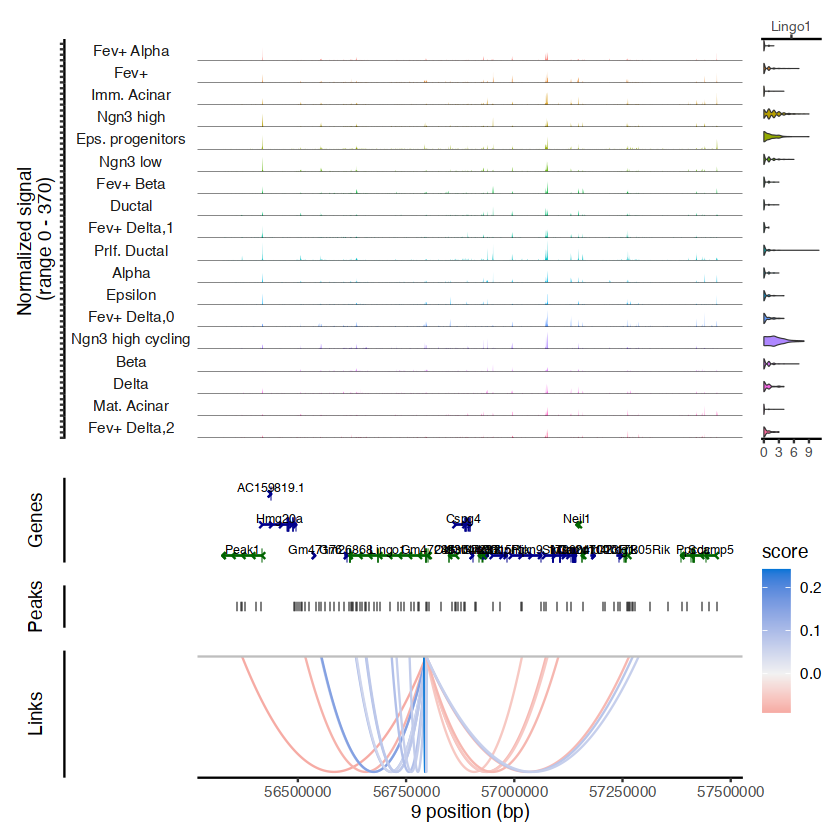

In [161]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[15]])

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



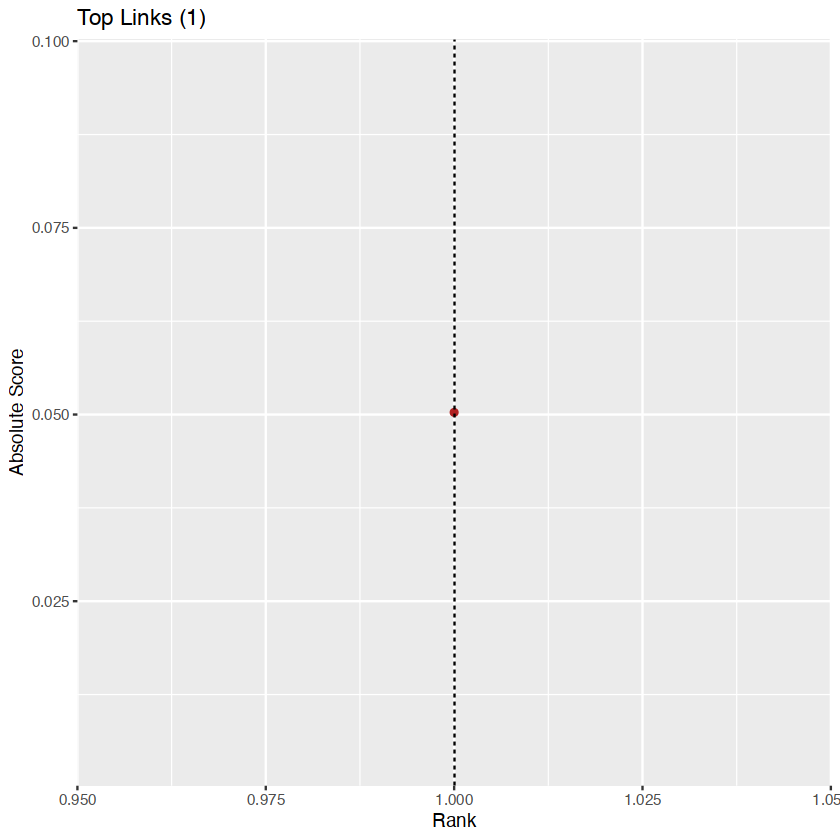

[1] "8-62952109-62953017"
# A tibble: 18 × 6
   celltype            mean     n   q25   q50   q75
   <chr>              <dbl> <int> <dbl> <dbl> <dbl>
 1 Alpha             0.104    460     0     0     0
 2 Beta              0.0827   588     0     0     0
 3 Delta             0.197     77     0     0     0
 4 Ductal            0.253   2906     0     0     0
 5 Eps. progenitors  0.177    204     0     0     0
 6 Epsilon           0.0671   247     0     0     0
 7 Fev+              0.101   1134     0     0     0
 8 Fev+ Alpha        0.0927   433     0     0     0
 9 Fev+ Beta         0.104    833     0     0     0
10 Fev+ Delta,0      0.277     61     0     0     0
11 Fev+ Delta,1      0.264     60     0     0     0
12 Fev+ Delta,2      0.154     55     0     0     0
13 Imm. Acinar       0.237   1928     0     0     0
14 Mat. Acinar       0.163   1322     0     0     0
15 Ngn3 high         0.108   3898     0     0     0
16 Ngn3 high cycling 0.192    139     0     0     0
17 Ngn3 low        

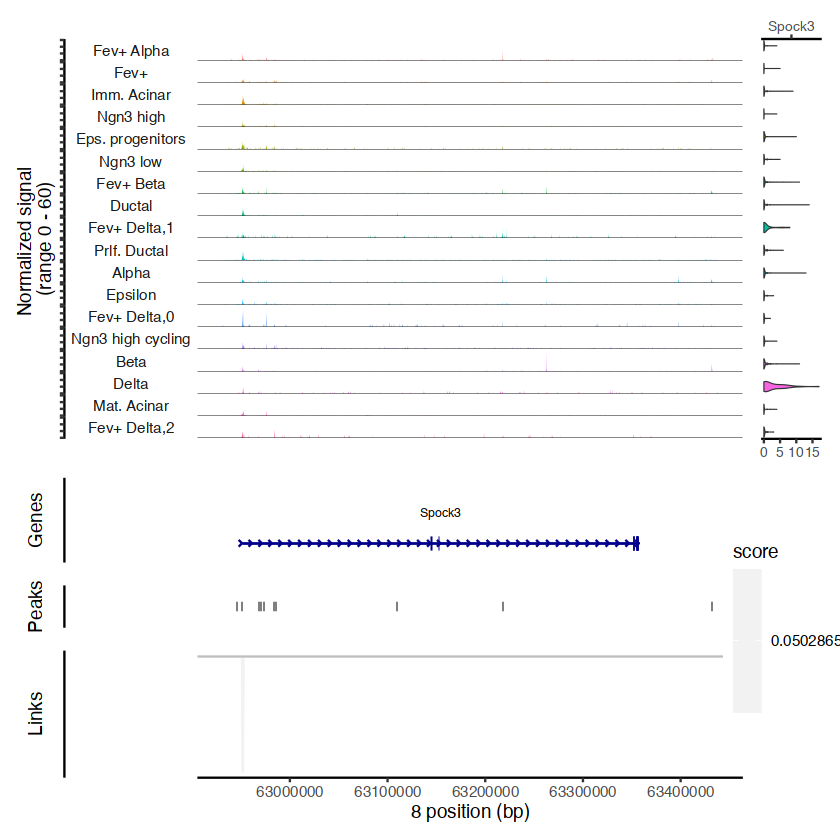

In [162]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[16]])

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



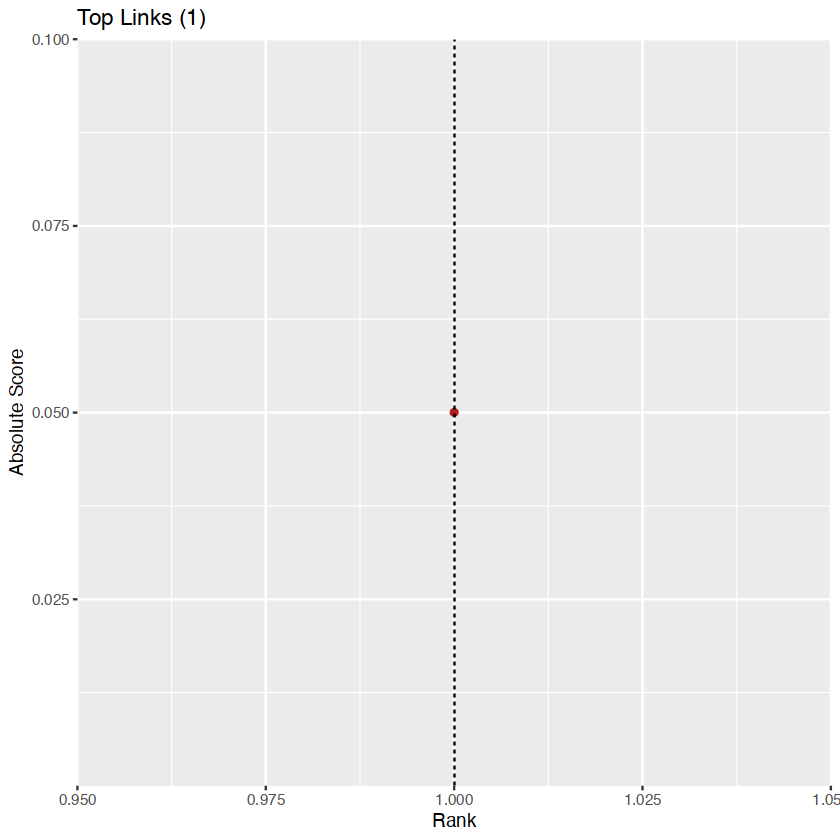

[1] "10-112732280-112733191"
# A tibble: 18 × 6
   celltype             mean     n   q25   q50   q75
   <chr>               <dbl> <int> <dbl> <dbl> <dbl>
 1 Alpha             0.415     460     0     0     0
 2 Beta              0.551     588     0     0     0
 3 Delta             0.171      77     0     0     0
 4 Ductal            0.0106   2906     0     0     0
 5 Eps. progenitors  0.0622    204     0     0     0
 6 Epsilon           0.243     247     0     0     0
 7 Fev+              0.161    1134     0     0     0
 8 Fev+ Alpha        0.286     433     0     0     0
 9 Fev+ Beta         0.142     833     0     0     0
10 Fev+ Delta,0      0.410      61     0     0     0
11 Fev+ Delta,1      0.244      60     0     0     0
12 Fev+ Delta,2      0.115      55     0     0     0
13 Imm. Acinar       0.0140   1928     0     0     0
14 Mat. Acinar       0.00918  1322     0     0     0
15 Ngn3 high         0.0612   3898     0     0     0
16 Ngn3 high cycling 0.0866    139     0     0     

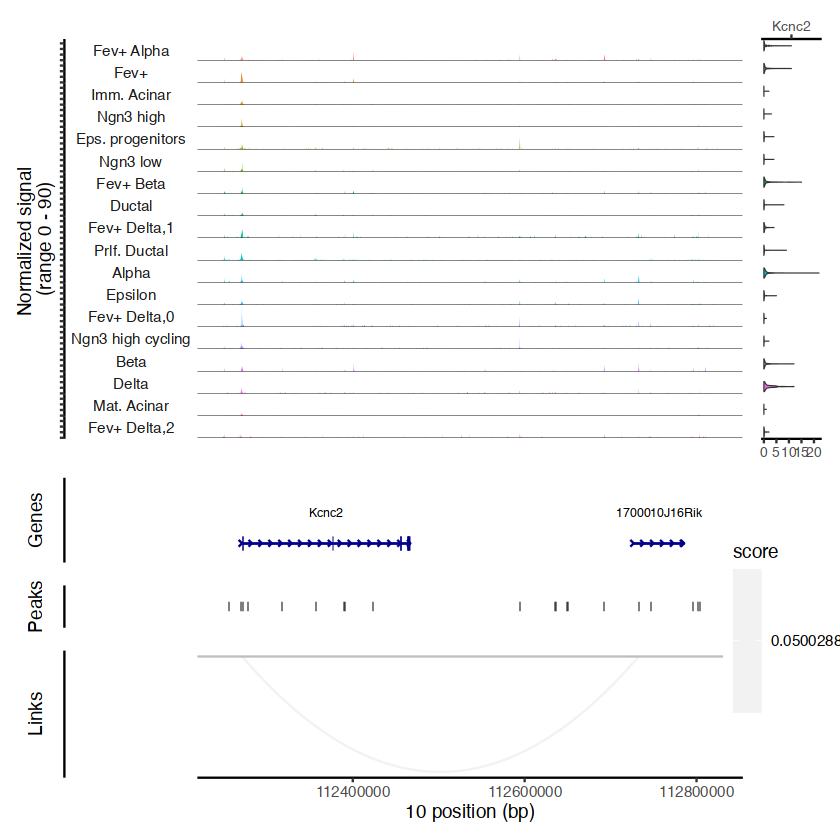

In [163]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[17]])

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



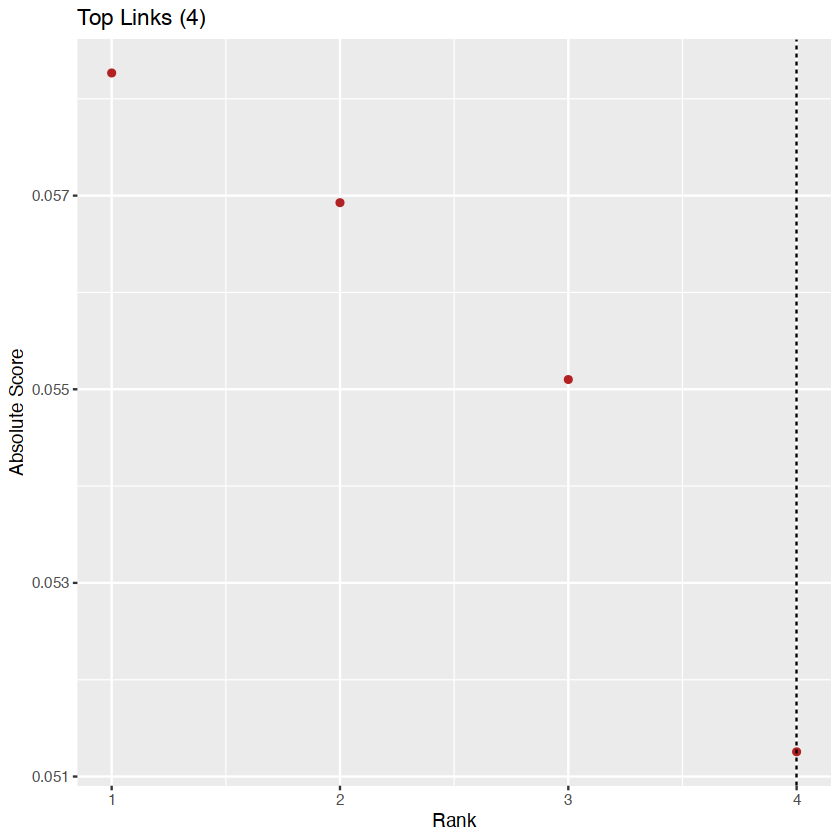

[1] "16-96736214-96737118"
# A tibble: 18 × 6
   celltype             mean     n   q25   q50   q75
   <chr>               <dbl> <int> <dbl> <dbl> <dbl>
 1 Alpha             0.659     460     0     0     0
 2 Beta              0.671     588     0     0     0
 3 Delta             0.168      77     0     0     0
 4 Ductal            0.00340  2906     0     0     0
 5 Eps. progenitors  0         204     0     0     0
 6 Epsilon           0.165     247     0     0     0
 7 Fev+              0.0988   1134     0     0     0
 8 Fev+ Alpha        0.361     433     0     0     0
 9 Fev+ Beta         0.311     833     0     0     0
10 Fev+ Delta,0      0.0791     61     0     0     0
11 Fev+ Delta,1      0.345      60     0     0     0
12 Fev+ Delta,2      0.0643     55     0     0     0
13 Imm. Acinar       0.00146  1928     0     0     0
14 Mat. Acinar       0.00195  1322     0     0     0
15 Ngn3 high         0.0152   3898     0     0     0
16 Ngn3 high cycling 0.0496    139     0     0     0


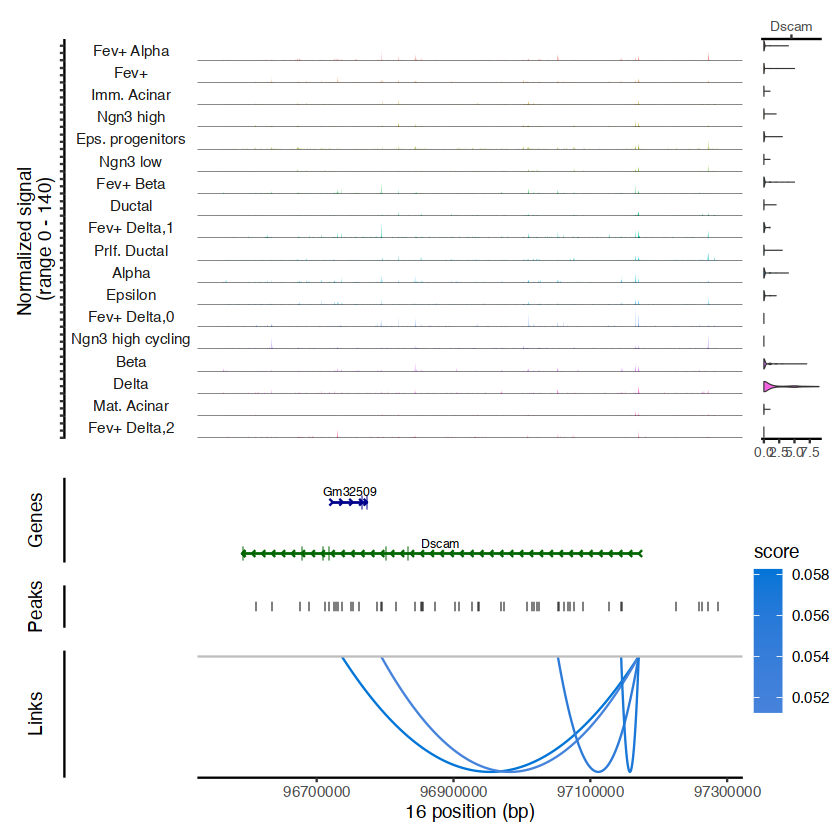

In [164]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[18]])

In [165]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[19]])

[1] "No links detected for this gene"


ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'nrow': Indizierung außerhalb der Grenzen


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message:
“Removed 96 rows containing missing values (geom_segment).”


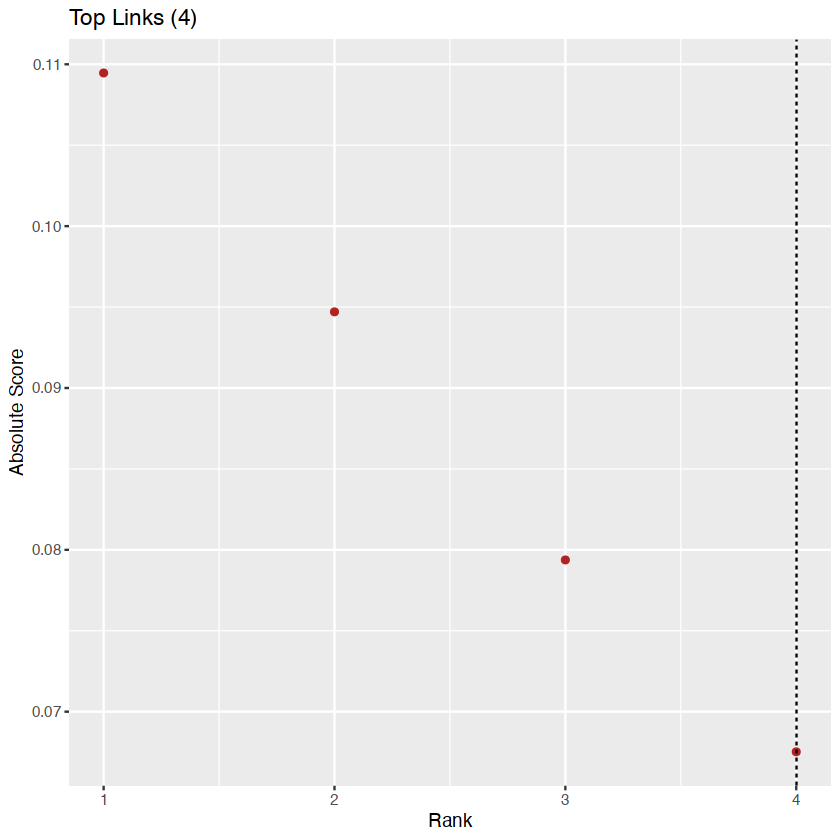

[1] "6-22941340-22942257"
# A tibble: 18 × 6
   celltype             mean     n   q25   q50   q75
   <chr>               <dbl> <int> <dbl> <dbl> <dbl>
 1 Alpha             0.467     460     0     0     0
 2 Beta              0.536     588     0     0     0
 3 Delta             0.273      77     0     0     0
 4 Ductal            0.00987  2906     0     0     0
 5 Eps. progenitors  0         204     0     0     0
 6 Epsilon           0.0466    247     0     0     0
 7 Fev+              0.00284  1134     0     0     0
 8 Fev+ Alpha        0.0182    433     0     0     0
 9 Fev+ Beta         0.153     833     0     0     0
10 Fev+ Delta,0      0          61     0     0     0
11 Fev+ Delta,1      0.295      60     0     0     0
12 Fev+ Delta,2      0          55     0     0     0
13 Imm. Acinar       0.0118   1928     0     0     0
14 Mat. Acinar       0.0151   1322     0     0     0
15 Ngn3 high         0.00932  3898     0     0     0
16 Ngn3 high cycling 0.0454    139     0     0     0
1

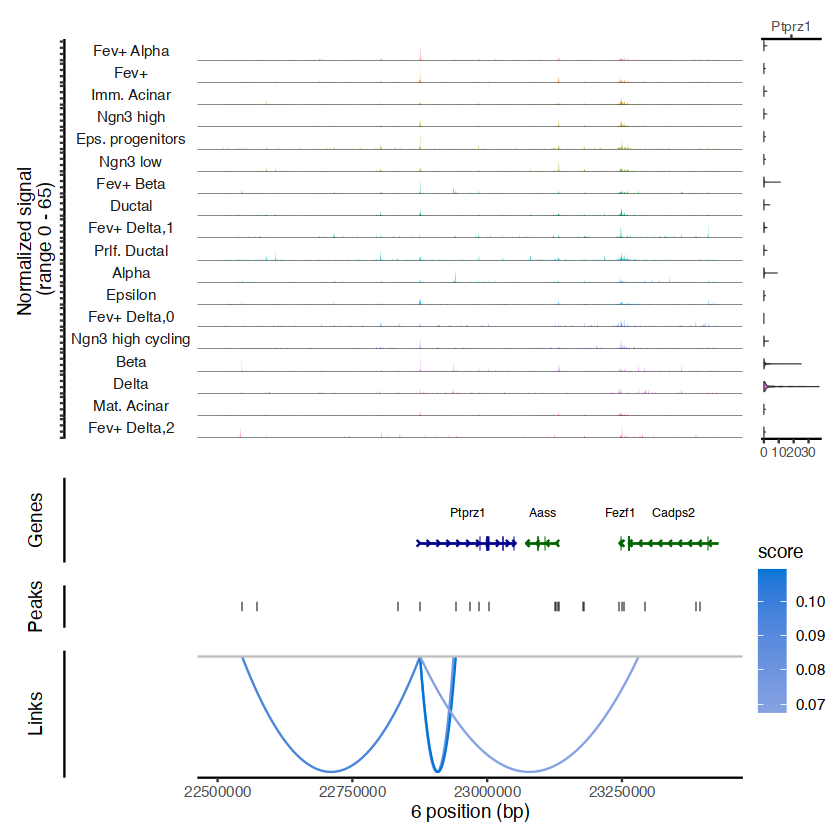

In [166]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[20]])

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message:
“Removed 204 rows containing missing values (geom_segment).”


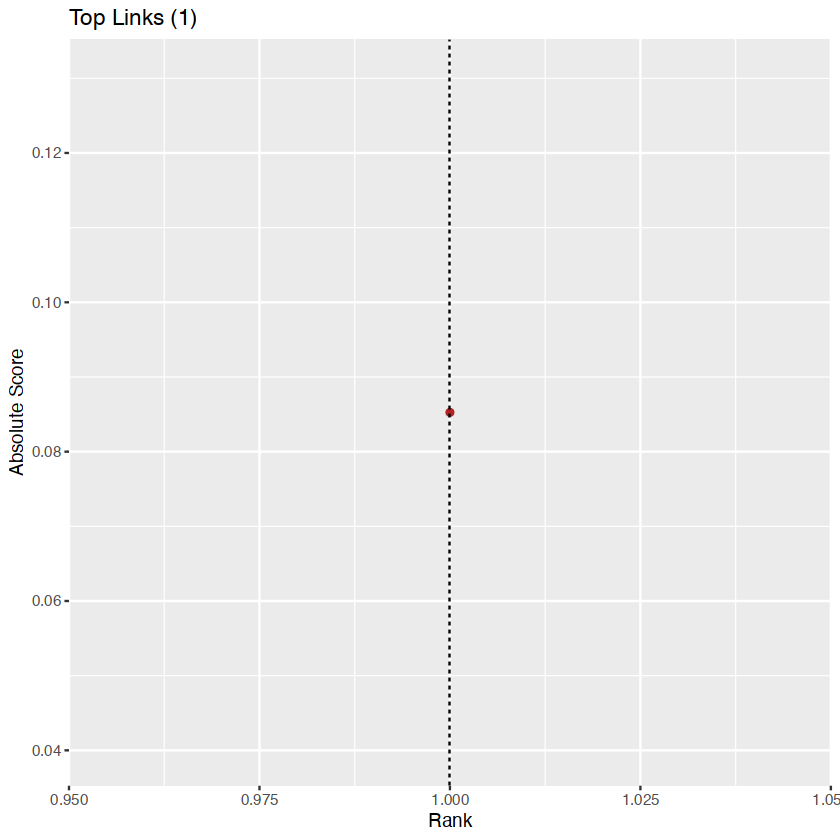

[1] "2-145936712-145937602"
# A tibble: 18 × 6
   celltype            mean     n   q25   q50   q75
   <chr>              <dbl> <int> <dbl> <dbl> <dbl>
 1 Alpha             0.548    460     0     0  1.53
 2 Beta              0.337    588     0     0  0   
 3 Delta             0.256     77     0     0  0   
 4 Ductal            0.0225  2906     0     0  0   
 5 Eps. progenitors  0.114    204     0     0  0   
 6 Epsilon           0.288    247     0     0  0   
 7 Fev+              0.396   1134     0     0  0   
 8 Fev+ Alpha        0.735    433     0     0  1.80
 9 Fev+ Beta         0.620    833     0     0  1.73
10 Fev+ Delta,0      0.535     61     0     0  1.29
11 Fev+ Delta,1      0.663     60     0     0  1.71
12 Fev+ Delta,2      0.306     55     0     0  0   
13 Imm. Acinar       0.0387  1928     0     0  0   
14 Mat. Acinar       0.0270  1322     0     0  0   
15 Ngn3 high         0.158   3898     0     0  0   
16 Ngn3 high cycling 0.149    139     0     0  0   
17 Ngn3 low      

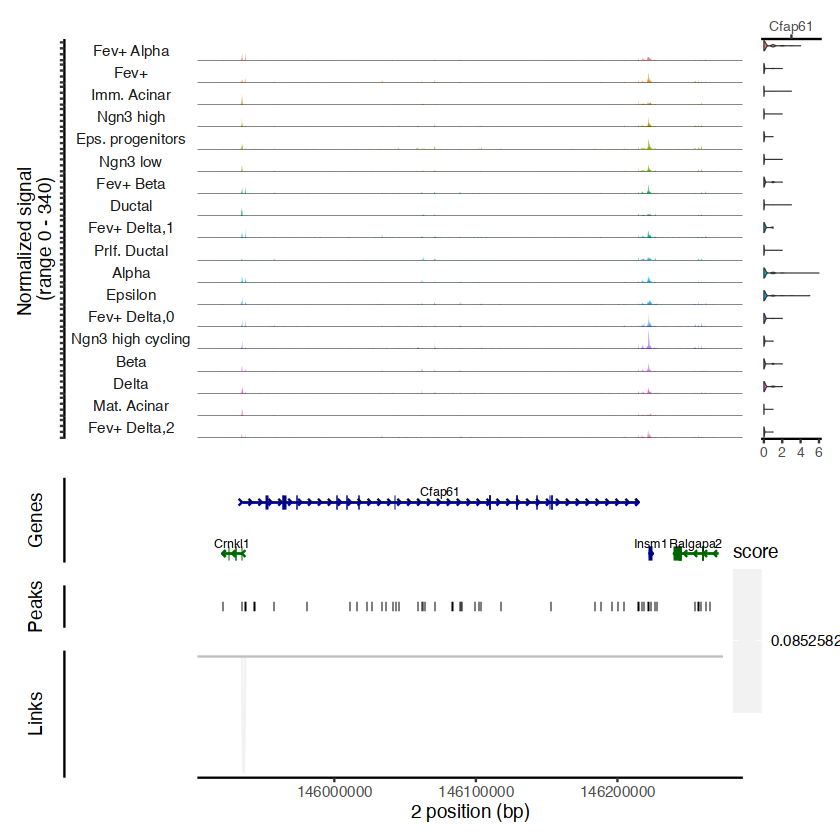

In [ ]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[21]])

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



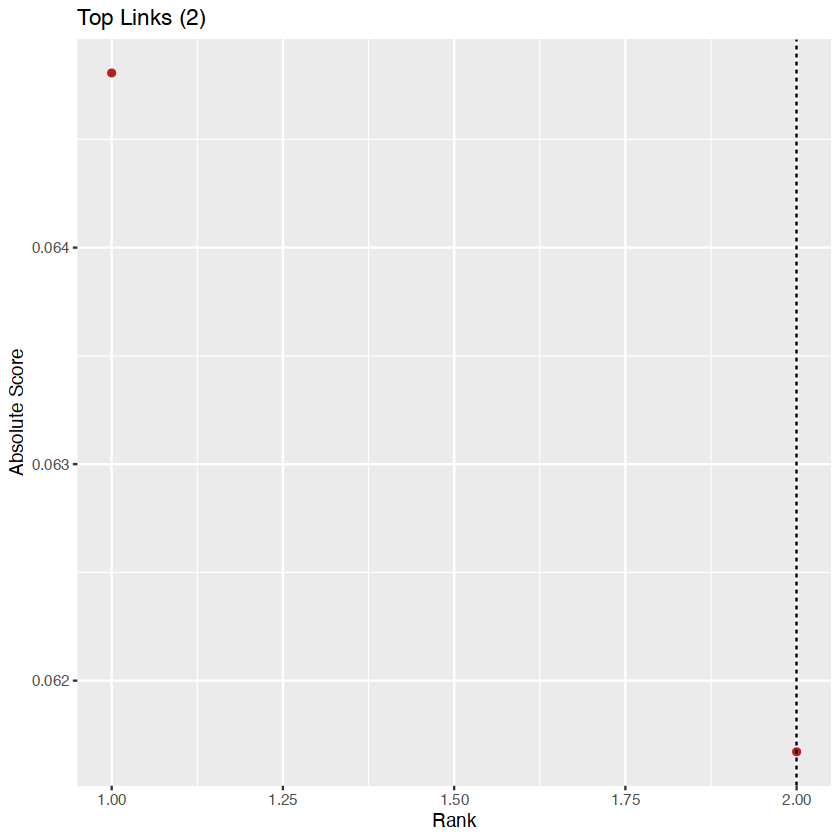

[1] "7-54565524-54566400"
# A tibble: 18 × 6
   celltype             mean     n   q25   q50   q75
   <chr>               <dbl> <int> <dbl> <dbl> <dbl>
 1 Alpha             0.434     460     0     0     0
 2 Beta              0.209     588     0     0     0
 3 Delta             0.156      77     0     0     0
 4 Ductal            0.00926  2906     0     0     0
 5 Eps. progenitors  0         204     0     0     0
 6 Epsilon           0.0158    247     0     0     0
 7 Fev+              0.0325   1134     0     0     0
 8 Fev+ Alpha        0.202     433     0     0     0
 9 Fev+ Beta         0.0917    833     0     0     0
10 Fev+ Delta,0      0.0663     61     0     0     0
11 Fev+ Delta,1      0.137      60     0     0     0
12 Fev+ Delta,2      0.0766     55     0     0     0
13 Imm. Acinar       0.0169   1928     0     0     0
14 Mat. Acinar       0.0142   1322     0     0     0
15 Ngn3 high         0.0101   3898     0     0     0
16 Ngn3 high cycling 0         139     0     0     0
1

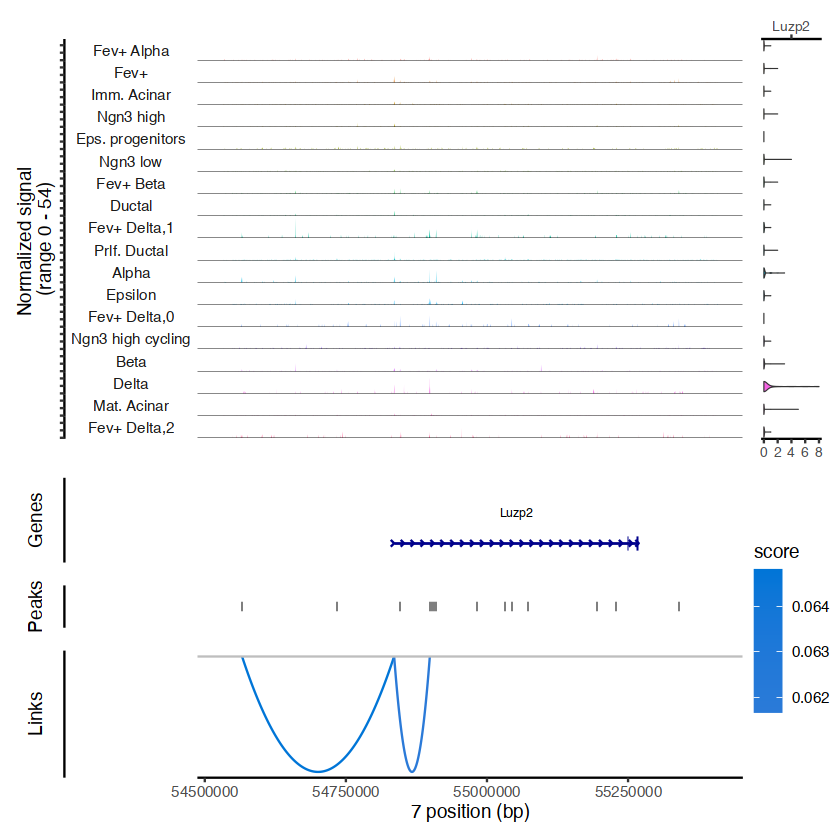

In [ ]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[22]])

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message:
“Removed 6 rows containing missing values (geom_segment).”


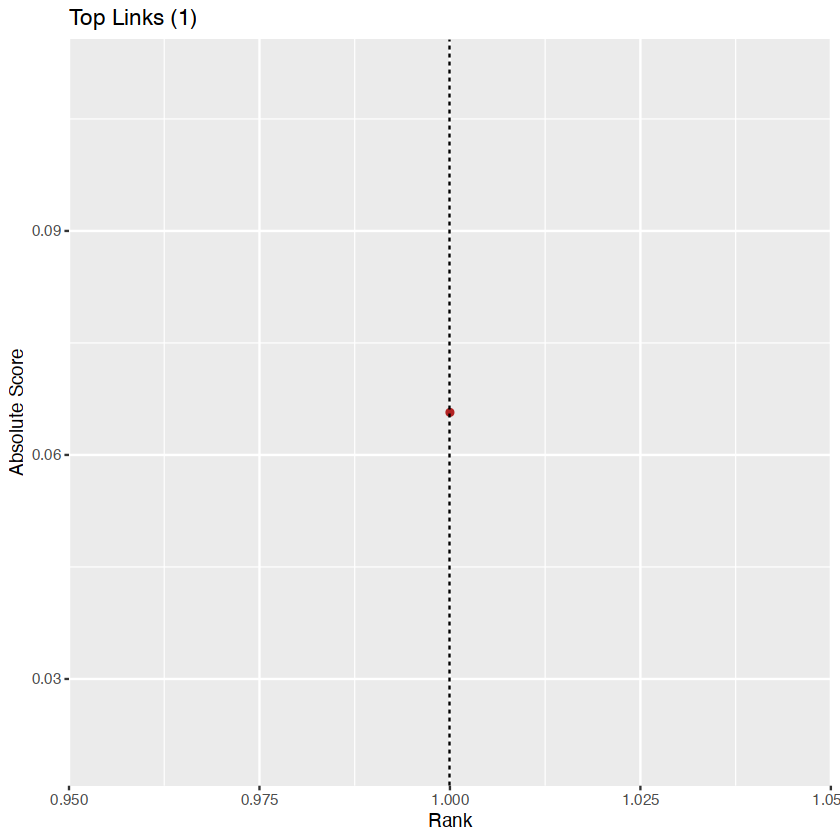

[1] "13-104931574-104932455"
# A tibble: 18 × 6
   celltype            mean     n   q25   q50   q75
   <chr>              <dbl> <int> <dbl> <dbl> <dbl>
 1 Alpha             0.115    460     0     0     0
 2 Beta              0.299    588     0     0     0
 3 Delta             0.413     77     0     0     0
 4 Ductal            0.0443  2906     0     0     0
 5 Eps. progenitors  0.227    204     0     0     0
 6 Epsilon           0.163    247     0     0     0
 7 Fev+              0.131   1134     0     0     0
 8 Fev+ Alpha        0.107    433     0     0     0
 9 Fev+ Beta         0.365    833     0     0     0
10 Fev+ Delta,0      0.286     61     0     0     0
11 Fev+ Delta,1      0.346     60     0     0     0
12 Fev+ Delta,2      0.355     55     0     0     0
13 Imm. Acinar       0.0416  1928     0     0     0
14 Mat. Acinar       0.0333  1322     0     0     0
15 Ngn3 high         0.0556  3898     0     0     0
16 Ngn3 high cycling 0.0450   139     0     0     0
17 Ngn3 low     

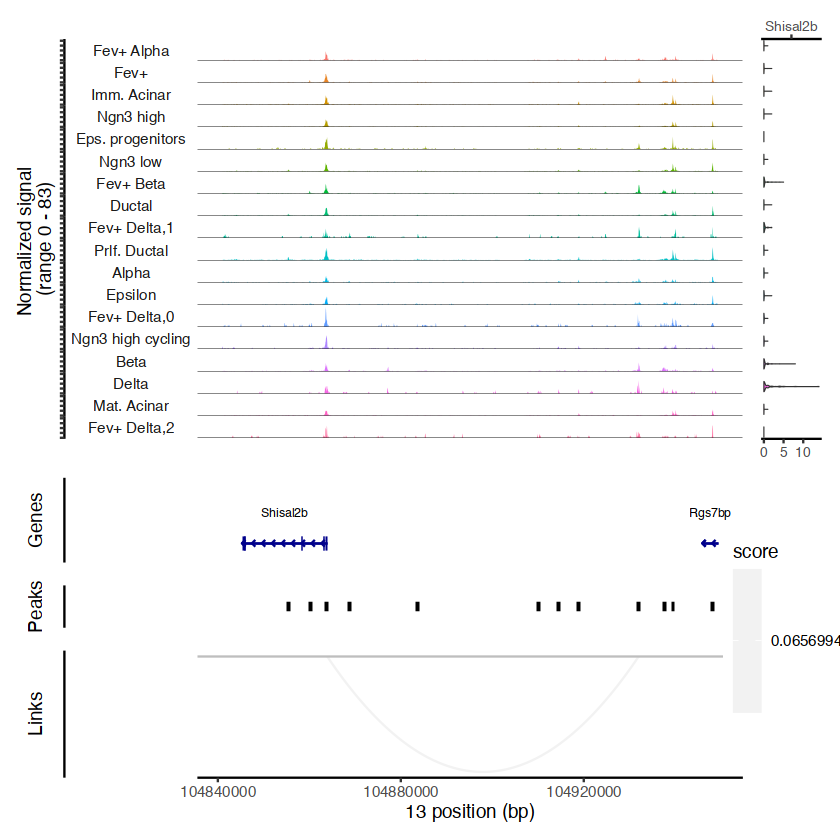

In [ ]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[23]])

In [ ]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[24]])

[1] "No links detected for this gene"


ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'nrow': Indizierung außerhalb der Grenzen


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message:
“Removed 9 rows containing missing values (geom_segment).”


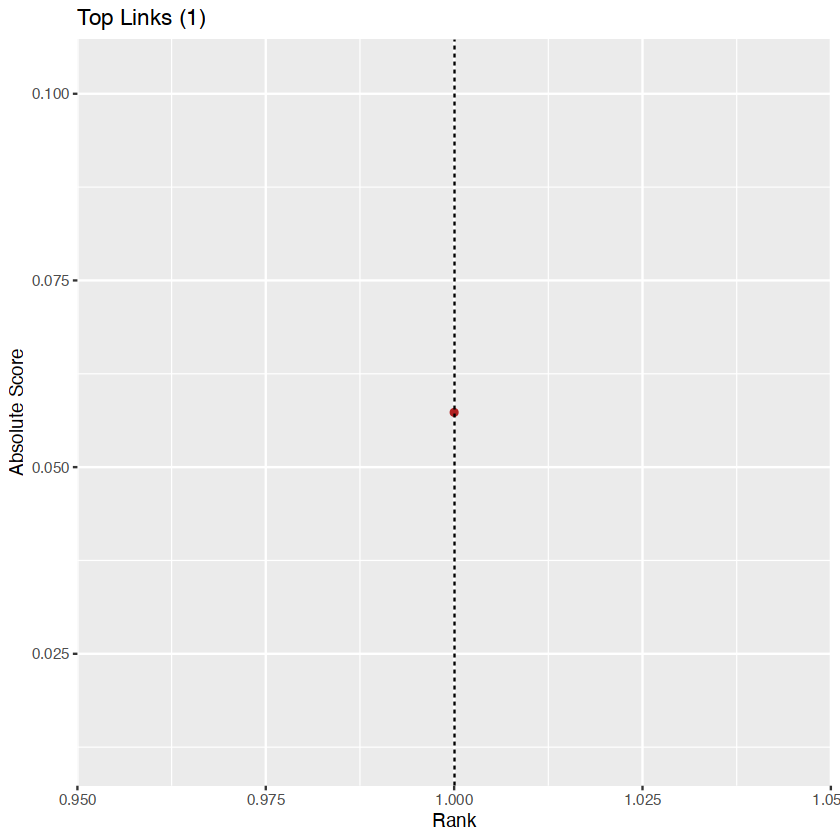

[1] "16-42661574-42662479"
# A tibble: 18 × 6
   celltype             mean     n   q25   q50   q75
   <chr>               <dbl> <int> <dbl> <dbl> <dbl>
 1 Alpha             0.792     460     0     0  2.37
 2 Beta              0.449     588     0     0  0   
 3 Delta             0.657      77     0     0  0   
 4 Ductal            0.0124   2906     0     0  0   
 5 Eps. progenitors  0.131     204     0     0  0   
 6 Epsilon           0.703     247     0     0  1.75
 7 Fev+              0.141    1134     0     0  0   
 8 Fev+ Alpha        0.248     433     0     0  0   
 9 Fev+ Beta         0.391     833     0     0  0   
10 Fev+ Delta,0      0.377      61     0     0  0   
11 Fev+ Delta,1      0.930      60     0     0  2.40
12 Fev+ Delta,2      0.276      55     0     0  0   
13 Imm. Acinar       0.00990  1928     0     0  0   
14 Mat. Acinar       0.00797  1322     0     0  0   
15 Ngn3 high         0.0340   3898     0     0  0   
16 Ngn3 high cycling 0.0878    139     0     0  0   


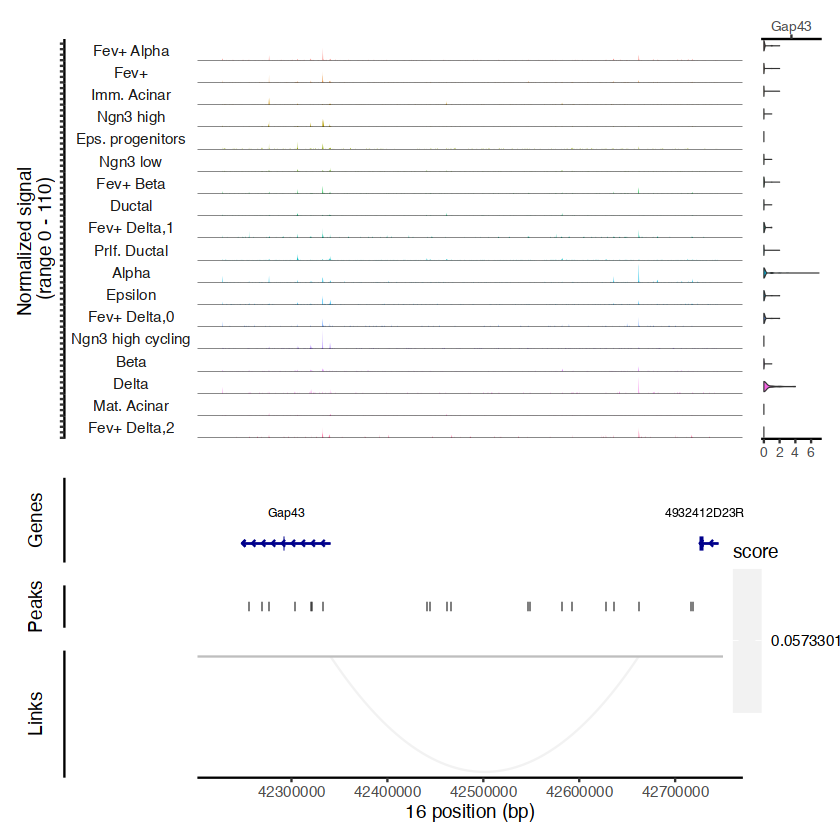

In [171]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[25]])

In [172]:
get_results(seurat, "Fev_delta_refinement", delta_markers[[26]])

[1] "No links detected for this gene"


ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'nrow': Indizierung außerhalb der Grenzen


[1] "No links detected for this gene"


ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'nrow': Indizierung außerhalb der Grenzen


In [174]:
seurat <- LinkPeaks(
  object = seurat,
  peak.assay = "ATAC_merged",
  expression.assay = "RNA",
  genes.use = "Isl1"
)

Testing 1 genes and 228257 peaks



Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



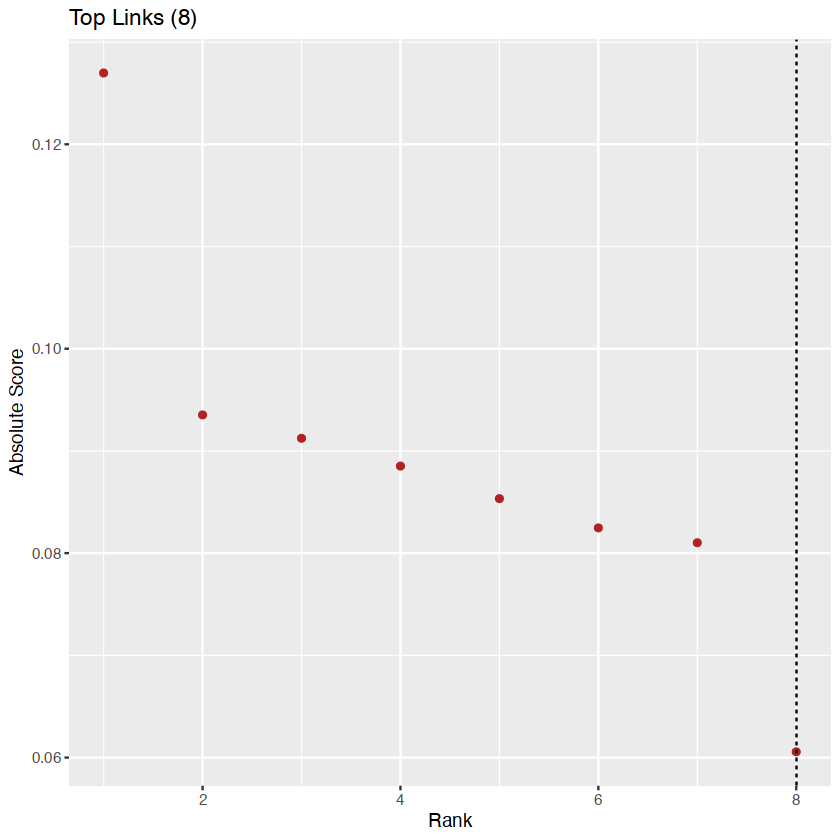

[1] "13-116335498-116336407"
# A tibble: 18 × 6
   celltype             mean     n   q25   q50   q75
   <chr>               <dbl> <int> <dbl> <dbl> <dbl>
 1 Alpha             0.403     460     0     0     0
 2 Beta              0.214     588     0     0     0
 3 Delta             0.235      77     0     0     0
 4 Ductal            0.0145   2906     0     0     0
 5 Eps. progenitors  0.131     204     0     0     0
 6 Epsilon           0.282     247     0     0     0
 7 Fev+              0.115    1134     0     0     0
 8 Fev+ Alpha        0.246     433     0     0     0
 9 Fev+ Beta         0.146     833     0     0     0
10 Fev+ Delta,0      0.203      61     0     0     0
11 Fev+ Delta,1      0.425      60     0     0     0
12 Fev+ Delta,2      0.309      55     0     0     0
13 Imm. Acinar       0.0133   1928     0     0     0
14 Mat. Acinar       0.0157   1322     0     0     0
15 Ngn3 high         0.0559   3898     0     0     0
16 Ngn3 high cycling 0.140     139     0     0     

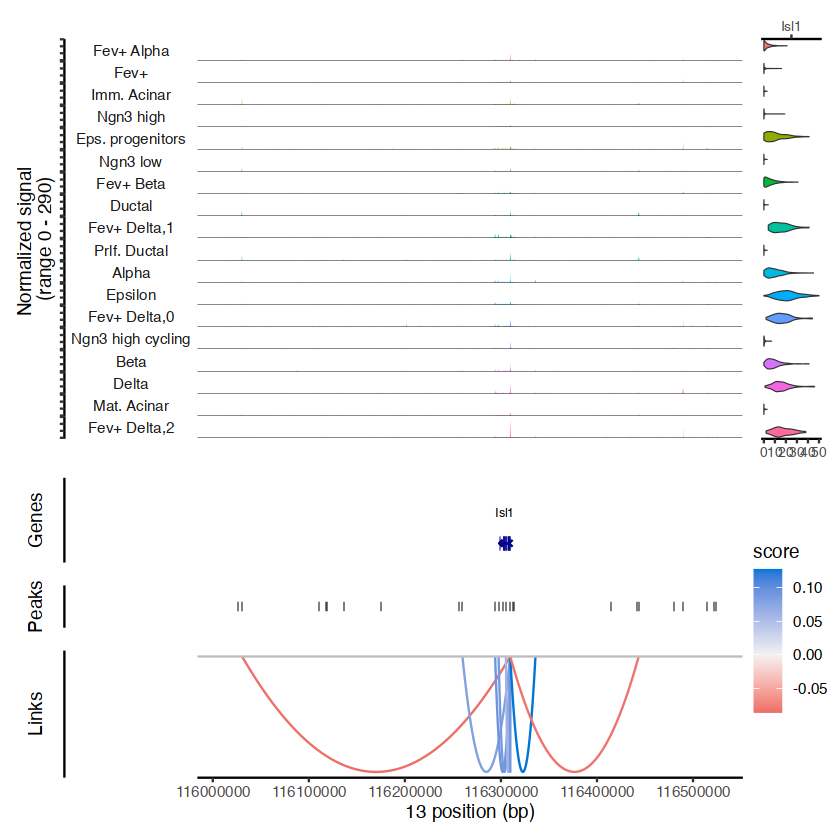

In [175]:
get_results(seurat, "Fev_delta_refinement", "Isl1")